In [17]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport

In [18]:
train_data = pd.read_csv("../minicomp-rossman/data/train.csv").reset_index(drop=True)
store_data = pd.read_csv("../minicomp-rossman/data/store.csv").reset_index(drop=True)

store_data['CompetitionDistance'] = store_data['CompetitionDistance'].fillna(75000)

/Users/sinarampe/opt/anaconda3/envs/mini_comp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
def add_time_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df['Year'] = df.Date.dt.year - 2013
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['DayOfWeek'] = df.Date.dt.dayofweek
    df['WeekOfYear'] = df.Date.dt.isocalendar().week.astype(int)
    df = df.drop(labels = "Date", axis=1)
    return df

In [20]:
def drop_nans_nulls_closed(df):
    df = df[df["Open"]==1]
    df = df[df["Sales"]!=0]
    df = df.dropna(subset = ["Store", "Open", "Promo", "StateHoliday", "SchoolHoliday", "Sales"])
    df["StateHoliday"].replace({0.0: "0"}, inplace=True)
    return df

In [21]:
def drop_cols(df):
    df = df.drop(labels = ["Customers"], axis=1)
    return df

In [22]:
train_data = add_time_features(train_data)
train_data = drop_nans_nulls_closed(train_data)
train_data = drop_cols(train_data)

In [23]:
merged_train = pd.merge(train_data, store_data, how='left', on="Store")

In [24]:
def recode(df, var_list=[]):
    map_dict = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    for v in var_list:
        df[v].replace(map_dict, inplace=True)
    return df

merged_train = recode(merged_train, ['StoreType', 'Assortment', 'StateHoliday'])

In [25]:
def month_to_str(df):
    map_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    df['month_str'] = df.Month.map(map_dict)
    return df

merged_train = month_to_str(merged_train)

In [26]:
def check_promo(row):
    if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
    else:
            return 0

In [27]:
merged_train['PromoMonth'] =  merged_train.apply(lambda row: check_promo(row),axis=1)    

In [28]:
merged_train['month_sin'] = np.sin(2 * np.pi * merged_train['Month']/12.0)
merged_train['month_cos'] = np.cos(2 * np.pi * merged_train['Month']/12.0)

merged_train['dayM_sin'] = np.sin(2 * np.pi * merged_train['Day']/30.0)
merged_train['dayM_cos'] = np.cos(2 * np.pi * merged_train['Day']/30.0)

In [29]:
encoder = TargetEncoder()
merged_train['Store_encoded'] = encoder.fit_transform(merged_train['Store'], merged_train['Sales'])


## load and prepare Holdout_data 

In [30]:
holdout_data = pd.read_csv("../minicomp-rossman/data/holdout_b29.csv")

In [31]:
holdout_data = holdout_data.rename(columns={"Unnamed: 0": "Id"})
holdout_data["Id"] = holdout_data["Id"] + 1

In [32]:
def drop_nn(df):
    df = df[df["Open"]==1]
    df = df.dropna(subset = ["Store", "Open", "Promo", "StateHoliday", "SchoolHoliday"])
    df["StateHoliday"].replace({0.0: "0"}, inplace=True)
    return df

In [33]:
holdout_data = add_time_features(holdout_data)
holdout_data = drop_nn(holdout_data)
holdout_data = drop_cols(holdout_data)

In [34]:
merged_holdout = pd.merge(holdout_data, store_data, how='left', on="Store")
merged_holdout = recode(merged_holdout, ['StoreType', 'Assortment', 'StateHoliday'])
merged_holdout = month_to_str(merged_holdout)
merged_holdout['PromoMonth'] =  merged_holdout.apply(lambda row: check_promo(row),axis=1)  

In [35]:
merged_holdout['month_sin'] = np.sin(2 * np.pi * merged_holdout['Month']/12.0)
merged_holdout['month_cos'] = np.cos(2 * np.pi * merged_holdout['Month']/12.0)

merged_holdout['dayM_sin'] = np.sin(2 * np.pi * merged_holdout['Day']/30.0)
merged_holdout['dayM_cos'] = np.cos(2 * np.pi * merged_holdout['Day']/30.0)

In [36]:
merged_holdout['Store_encoded'] = encoder.transform(merged_holdout['Store'])

#### ------------------------------

In [37]:
train = merged_train.iloc[:int(0.9*train_data.shape[0]), :]
eva = merged_train.iloc[int(0.9*train_data.shape[0]):int(0.95*train_data.shape[0]), :]
test = merged_train.iloc[int(0.95*train_data.shape[0]):, :]

In [38]:
import xgboost as xgb
from xgboost import plot_importance

In [39]:
target = 'Sales'

my_features = ['month_sin', 'month_cos', 'dayM_sin', 'dayM_cos', "Year", 'Month', 'WeekOfYear', 'DayOfWeek','StateHoliday', 'SchoolHoliday', 
               'CompetitionDistance', 'Promo2', 'StoreType', 'Assortment', 'Open', 'Promo', "PromoMonth", "Store_encoded"]

In [40]:
params = {"objective": "reg:squarederror", 
          "booster" : "gbtree", 
          "seed": 10 }

In [41]:
def metric(preds, actuals):
    preds = np.array(preds)
    actuals = np.array(actuals)
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [42]:
def xgboost_experiment(vars_list, experiment_name, params, num_boost_round):
    dtrain = xgb.DMatrix(train[vars_list], label=train['Sales'], enable_categorical=True)
    deva = xgb.DMatrix(eva[vars_list], label=eva['Sales'])
    dtest = xgb.DMatrix(test[vars_list], label=test['Sales'], enable_categorical=True)
    
    #train
    xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round, 
                      early_stopping_rounds=100, evals=[(deva, "Eval")], verbose_eval=False)

    # make prediction
    print('+++++ Results for experiment: ', experiment_name)
    pred = xgb_model.predict(dtest)
    print("Testerror")
    print(metric(test[target], pred))
    pred = xgb_model.predict(dtrain)
    print("Trainerror")
    print(metric(train[target], pred))
    return xgb_model

In [43]:
#num_boost_round_list = [100, 500, 1000]

#for n in num_boost_round_list:
#    print('### Experiment with ', str(n), ' boosting rounds')
#   xgboost_experiment(my_features, "my_features", params, n)

In [45]:
my_model = xgboost_experiment(my_features, "final", params, 1000)

+++++ Results for experiment:  final
Testerror
14.947331285130078
Trainerror
10.675767310457251


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

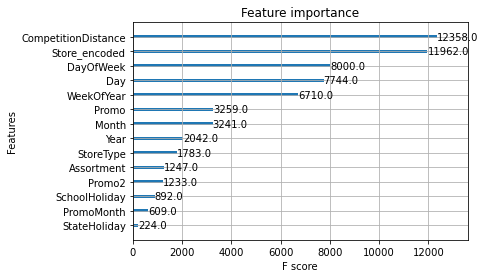

In [101]:
plot_importance(my_model)

In [28]:
merged_holdout[my_features].head(5)

,Store,Year,Month,Day,WeekOfYear,DayOfWeek,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,StoreType,Assortment,Open,Promo,PromoMonth
0,371,1,8,1,31,4,0,1,1970.0,1,4,3,1,1,1
1,372,1,8,1,31,4,0,1,4880.0,1,4,3,1,1,0
2,373,1,8,1,31,4,0,1,11120.0,1,4,3,1,1,0
3,380,1,8,1,31,4,0,1,2240.0,1,1,1,1,1,0
4,374,1,8,1,31,4,0,1,1150.0,0,1,1,1,1,0


In [29]:
xgtest = xgb.DMatrix(merged_holdout[my_features])

In [30]:
pred = my_model.predict(xgtest)

In [31]:
output = pd.DataFrame({'Id': holdout_data.Id, 'Sales': pred})
output.to_csv('Submission2.csv', index=False)

In [32]:
sub = pd.read_csv("Submission2.csv")
sub.head()

,Id,Sales
0,1,8119.1110
1,2,10948.4300
2,3,6395.9316
3,4,20013.1300
4,5,10836.1730
